In [4]:
import sys
import yaml
import tqdm
import numpy as np
from matplotlib import pyplot as plt

import data_loader.data_loaders as data


# open the config file
with open("config.yaml", "r", encoding="utf-8") as file:
    config = yaml.safe_load(file)

data_config = config["data"]
train_loader = data.create_data_loader(data_config, train=True, examine=True)

iterator = tqdm.tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/205942 [00:00<?, ?it/s]

In [ ]:
# aggregate positions
all_positions = []
for batch in iterator:
    input_positions = np.array([datum["p_in"] for datum in batch])

    # convert from shape (datum, agent, timestamp, x/y) to (x/y)
    num_datums, num_agents, num_timestamps, num_xy = input_positions.shape    
    input_positions = input_positions.reshape(num_datums * num_agents * num_timestamps, num_xy)

    # remove all the zero positions
    input_positions = input_positions[np.any(input_positions != 0, axis=1)]

    all_positions.append(input_positions)
    
all_positions = np.concatenate(all_positions)
x = list(all_positions[:, 0])
y = list(all_positions[:, 1])

# plot all of the positions
plt.scatter(x, y, s=0.01)
plt.savefig('naive_positions.png')

(60, 2)


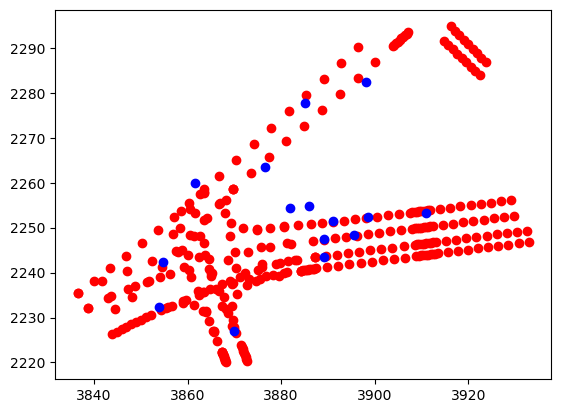

In [23]:

def plot_timestamp(scene, timestamp):
    positions = np.array(scene["p_in"])
    positions = positions[:, timestamp, :]
    print(positions.shape)

    # remove 0, 0 positions
    positions = positions[np.any(positions != 0, axis=1)]

    lane_positions = scene["lane"]
    lane_norms = scene["lane_norm"]

    # plot the lanes
    for lane_position, lane_norm in zip(lane_positions, lane_norms):
        directional_position = lane_position + lane_norm
        plt.scatter(
            lane_position[0], lane_position[1], color="red")

    # plot the agents
    for position in positions:
        plt.scatter(position[0], position[1], color="blue")
    
    plt.show()

# plot a scene
scene = train_loader.dataset[10]
plot_timestamp(scene, 8)


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Ensure interactive mode is enabled for Jupyter Notebook
%matplotlib notebook

colors = ["blue", "red", "green", "orange", "purple", "pink", "olive", "cyan"]

def update_plot(timestamp, scene, ax):
    ax.clear()  # Clear the current plot

    scene_timestamp = timestamp

    if timestamp < len(scene["p_in"][0]):
        predicting = "Input Data"
        positions = np.array(scene["p_in"])
        velocities = np.array(scene["v_in"])
    else:
        predicting = "Output Data"
        positions = np.array(scene["p_out"])
        velocities = np.array(scene["v_out"])
        timestamp -= len(scene["p_in"][0])

    positions = positions[:, timestamp, :]
    positions = positions[np.any(positions != 0, axis=1)]  # Remove 0, 0 positions

    velocities = velocities[:, timestamp, :]
    velocities = velocities[np.any(velocities != 0, axis=1)]  # Remove 0, 0 velocities

    lane_positions = scene["lane"]
    lane_norms = scene["lane_norm"]

    # Plot the lanes
    for lane_position, lane_norm in zip(lane_positions, lane_norms):
        ax.arrow(
            lane_position[0], lane_position[1],
            lane_norm[0], lane_norm[1],
            width=0.05,
            color="black"
        )

    # Plot the agents
    for i, position in enumerate(positions):
        color = colors[i % len(colors)]
        ax.scatter(position[0], position[1], color=color, s=10)

    # plot the velocities
    for i, velocity in enumerate(velocities):
        color = colors[i % len(colors)]
        ax.arrow(
            positions[i][0], positions[i][1],
            velocity[0], velocity[1],
            width=0.05,
            color=color
        )


    # prepend space if in single digits
    scene_timestamp = str(scene_timestamp).rjust(2, "0")

    ax.set_title(f"{predicting}. Timestamp: {scene_timestamp}")

    # Set the x and y axis labels
    ax.set_xlabel("X")
    ax.set_ylabel("Y")


def animate(scene, filename='animation.gif'):
    fig, ax = plt.subplots()
    num_timestamps = len(scene["p_in"][0]) + len(scene["p_out"][0])
    ani = animation.FuncAnimation(
        fig,
        update_plot,
        frames=range(num_timestamps),
        fargs=(scene, ax),
        interval=100,  # Time in milliseconds between frames
        repeat=True
    )

    # Save the animation as a GIF
    ani.save(filename, writer='pillow', fps=10)

    # Display the saved GIF
    return HTML(ani.to_jshtml())

# Plot a scene: 10, 100
scene = train_loader.dataset[100]
animation = animate(scene, filename='animation.gif')
# display(animation)


<IPython.core.display.Javascript object>